In [1]:
import pandas as pd
import numpy as np
import yaml
import importlib
from copy import deepcopy
from pathlib import Path
from scripts import import_preprocessing1, data_filtering2, microbiome_filtering3, level_filtering4
import subprocess

from scipy.stats import friedmanchisquare
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu

from IPython.display import IFrame

importlib.reload(import_preprocessing1)
importlib.reload(data_filtering2)
importlib.reload(microbiome_filtering3)
importlib.reload(level_filtering4)

<module 'scripts.level_filtering4' from '/ceph/projects/179_Oncdon/shawn.loo/workspace/scripts/level_filtering4.py'>

In [2]:
import_str = "/ceph/projects/179_Oncdon/shawn.loo/workspace/"

configs_path = Path(f"{import_str}configs/default_genera.yaml")
with open(configs_path) as w:
    config = yaml.safe_load(w)

# Metadata Handling

### Importing metadata

In [275]:
metadata_V107_w_inh = pd.read_excel("data/rawdata/CC_longitudinal_data_standardized_v220250603_reformatted.xlsx", sheet_name = "CC_longitudinal_metadata_w_inh")
metadata_E975_w_inh = pd.read_excel("data/rawdata/E100051975_BR_longitudinal_metadata_dev1_v220250603.xlsx", sheet_name = "BR_longitudinal_metadata_w_inh")

### Extracting required columns

In [276]:
columns_to_extract = ["sample_id", 
                      "pt_identifier",
                      "diagnosis", 
                      "lines_of_therapy",
                      "response (R = responder, NR =nonresponder; inside parenthesis is previous classification)",
                      "best_response (PD=progressive disease, SD=stable, PR=partial response, CR=complete response, MR=mixed response)",
                      "PFS_since_1stICI (progression free survival in months)",
                      "OS_since_1stICI (overall survival in months)"]

extract = ["sample_id", "response (R = responder, NR =nonresponder; inside parenthesis is previous classification)"]
ext2 = ["sample_id", "pt_identifier"]

metadata_V107_inh = metadata_V107_w_inh[extract]
metadataE975_inh = metadata_E975_w_inh[extract]

meta_V107_stats_df = metadata_V107_w_inh[ext2]
meta_E975_stats_df = metadata_E975_w_inh[ext2]

### Column cleaning

In [277]:
target_column = "response (R = responder, NR =nonresponder; inside parenthesis is previous classification)"

metadata_V107_inh.loc[:,target_column] = metadata_V107_inh.loc[:,target_column].str.replace(r"\s.*|\(.*", "", regex=True)
metadataE975_inh.loc[:,target_column] = metadataE975_inh.loc[:,target_column].str.replace(r"\s.*|\(.*", "", regex=True)

Group them based on Response

In [278]:
V107_res = metadata_V107_inh.groupby(target_column)
E975_res = metadataE975_inh.groupby(target_column)

In [279]:
V107_res_df = {}
E975_res_df = {}

for res, df in V107_res:
    V107_res_df[res] = df
    
for res, df in E975_res:
    E975_res_df[res] = df

In [296]:
V107_res_df

{'NR':           sample_id  \
 5        FF02556082   
 7     179supB00008a   
 8     179supB00009a   
 9     179supB00010a   
 13    179fece00003a   
 ..              ...   
 146  179fece000632a   
 150   179supD00619a   
 151   179supD00620a   
 152   179supD00621a   
 153   179supD00622a   
 
     response (R = responder, NR =nonresponder; inside parenthesis is previous classification)  
 5                                                   NR                                         
 7                                                   NR                                         
 8                                                   NR                                         
 9                                                   NR                                         
 13                                                  NR                                         
 ..                                                 ...                                         
 146                     

# Extracting based on raw data

In [284]:
dataset = import_preprocessing1.load_and_process_data()
filtered_dataset = data_filtering2.filter_data(dataset)
microbiome_filtered_df = microbiome_filtering3.run_microbiome_filtering(filtered_dataset, config)

In [285]:
data_V107 = microbiome_filtered_df["V107"].set_index("taxon_name")
data_V142 = microbiome_filtered_df["V142"].set_index("taxon_name")
data_E975 = microbiome_filtered_df["E975"].set_index("taxon_name")

In [298]:
# Merging V107 and V142, sharing same metadata
data_V107 = data_V107.join(data_V142, how="outer")

In [299]:
V107_df = {}

for res, df in V107_res_df.items():
    
    extracted_df = data_V107.loc[:, data_V107.columns.isin(df["sample_id"])]
    
    V107_df[res] = extracted_df
    

E975_df = {}

for res, df in E975_res_df.items():
    
    extracted_df = data_E975.loc[:, data_E975.columns.isin(df["sample_id"])]
    
    E975_df[res] = extracted_df
    

# Separating them into week 0 to week 6

In [303]:
V107_week_info = metadata_V107_w_inh[["sample_id", "sample_description"]]
E975_week_info = metadata_E975_w_inh[["sample_id", "sample_description"]]

# Extracting based on weeks (first and last week/experiment period)
V107_wk0 = V107_week_info.loc[V107_week_info["sample_description"] == "fece_wk0_a"]
V107_wk1 = V107_week_info.loc[V107_week_info["sample_description"] == "cul_wk1_a"]
V107_wk2 = V107_week_info.loc[V107_week_info["sample_description"] == "cul_wk2_a"]
V107_wk3 = V107_week_info.loc[V107_week_info["sample_description"] == "cul_wk3_a"]
V107_wk4 = V107_week_info.loc[V107_week_info["sample_description"] == "cul_wk4_a"]
V107_wk5 = V107_week_info.loc[V107_week_info["sample_description"] == "cul_wk5_a"]
V107_wk6 = V107_week_info.loc[V107_week_info["sample_description"] == "cul_wk6_a"]

E975_fs = E975_week_info.loc[E975_week_info["sample_description"] == "fecal_slurry"]
E975_day4 = E975_week_info.loc[E975_week_info["sample_description"] == "cul_Day4"]
E975_day8 = E975_week_info.loc[E975_week_info["sample_description"] == "cul_Day8"]
E975_day12 = E975_week_info.loc[E975_week_info["sample_description"] == "cul_Day12"]

In [304]:
def extract_weekly(main_df, week_samples_df):
    
    result = {}
    
    for res, df in main_df.items():

        # Extracting samples that only exists in the particular week
        extracted = df.loc[:, df.columns.isin(week_samples_df["sample_id"])]
        
        # Copying, avoid inplace modification
        extracted_cpy = extracted.copy()
        
        # Summing all samples up
        extracted_cpy["count"] = extracted_cpy.sum(axis=1)
        
        # Dropping empty rows
        extracted_cpy = extracted_cpy[extracted_cpy["count"] != 0]

        # Store
        result[res] = extracted_cpy[["count"]]
        
    return result

V107_week0_res = extract_weekly(V107_df, V107_wk0)
V107_week1_res = extract_weekly(V107_df, V107_wk1)
V107_week2_res = extract_weekly(V107_df, V107_wk2)
V107_week3_res = extract_weekly(V107_df, V107_wk3)
V107_week4_res = extract_weekly(V107_df, V107_wk4)
V107_week5_res = extract_weekly(V107_df, V107_wk5)
V107_week6_res = extract_weekly(V107_df, V107_wk6)

E975_day0_res = extract_weekly(E975_df, E975_fs)
E975_day4_res = extract_weekly(E975_df, E975_day4)
E975_day8_res = extract_weekly(E975_df, E975_day8)
E975_day12_res = extract_weekly(E975_df, E975_day12)

In [305]:
V107_week0_res.items()

dict_items([('NR',                                                       count
taxon_name                                                 
k__Archaea|p__Euryarchaeota|c__Methanobacteria|...  1.06398
k__Archaea|p__Euryarchaeota|c__Methanobacteria|...  1.06398
k__Archaea|p__Euryarchaeota|c__Methanobacteria|...  0.69945
k__Archaea|p__Euryarchaeota|c__Methanobacteria|...  0.36453
k__Bacteria|p__Actinobacteria|c__Actinomycetia|...  0.14810
...                                                     ...
k__Bacteria|p__Verrucomicrobia|c__Verrucomicrob...  9.64664
k__Bacteria|p__Verrucomicrobia|c__Verrucomicrob...  2.92460
k__Bacteria|p__Verrucomicrobia|c__Verrucomicrob...  6.72204
k__Bacteria|p__Verrucomicrobia|c__Verrucomicrob...  1.55258
k__Bacteria|p__Verrucomicrobia|c__Verrucomicrob...  1.55258

[1866 rows x 1 columns]), ('R',                                                       count
taxon_name                                                 
k__Archaea|p__Candidatus_Thermoplasmatota|c__Th.

In [306]:
# Creating time series data

def create_time_series(*df):
    
    df_R = []
    df_NR = []
    
    for data in df:
    
        for res, dataset in data.items():

            if res == "R":

                df_R.append(dataset)

            else:

                df_NR.append(dataset)
            
    return [df_R, df_NR]

            
            
V107_R, V107_NR = create_time_series(V107_week0_res, V107_week1_res, V107_week2_res, V107_week3_res, V107_week4_res, V107_week5_res, V107_week6_res)
E975_R, E975_NR = create_time_series(E975_day0_res, E975_day4_res, E975_day8_res, E975_day12_res)

In [307]:
# Renaming columns
for i, df in enumerate(V107_R):
    
    df.reset_index(inplace = True)
    df.rename(columns = {"count": f"week{i}"}, inplace=True)
    
for i, df in enumerate(V107_NR):
    
    df.reset_index(inplace = True)
    df.rename(columns = {"count": f"week{i}"}, inplace=True)
    
days = ["0", "4", "8", "12"]

for i in range(len(E975_R)):
    
    E975_R[i].reset_index(inplace = True)
    E975_R[i].rename(columns = {"count": f"day{days[i]}"}, inplace = True)
    
for i in range(len(E975_NR)):
    
    E975_NR[i].reset_index(inplace = True)
    E975_NR[i].rename(columns = {"count": f"day{days[i]}"}, inplace = True)


In [308]:
# Merging them
def merger(datasets):
    
    merged_df = datasets[0]
    
    for df in datasets[1:]:
        merged_df = pd.merge(merged_df, df, on = "taxon_name", how = "outer")
        
    merged_df = merged_df.fillna(0)
    merged_df.set_index("taxon_name", inplace = True)
    
    return merged_df

        
ts_V107_R = merger(V107_R)
ts_V107_NR = merger(V107_NR)
ts_E975_R = merger(E975_R)
ts_E975_NR = merger(E975_NR)

In [309]:
# Creating a phylum column
def level_filtering(df, filtering):

    # Resetting index
    df = df.reset_index(names = "taxon_name")
    
    # Level Map
    level_map = {
        "kingdom": "k__",
        "phylum": "p__",
        "class": "c__",
        "order": "o__",
        "family": "f__",
        "genus": "g__",
        "species": "s__"
        }

    level = level_map.get(filtering.lower())

    # Perform filtering based on passed in parameter mapped to Level Map and name the column
    phylum_new_column = df["taxon_name"].str.extract(fr'{level}([^|]+)')
    
    # Creating another column, genus
    genus_new_column = df["taxon_name"].str.extract(r"g__([^|]+)")[0]

    # Inserting new column
    df.insert(0, filtering, phylum_new_column)
    
    # Inserting genus column
    df.insert(1, "genus", genus_new_column)
    
    # Dropping NaN columns
    filtered_df = df.dropna(subset=["taxon_name"])

    return df

In [310]:
def groupUp_genus_col(df):

    # Dropping genus
    df = df.dropna(subset=["genus"])

    # Grouping by genus
    grouped_genus = df.groupby("genus").sum()

    # Retrieving phylum col value for each genus
    phylum_under_genus = df.groupby("genus")["phylum"].first()

    # Add phylum back as a column
    grouped_genus["phylum"] = phylum_under_genus

    # Reset index to get taxon_name back as a column
    grouped_genus.reset_index(inplace = True)

    # Dropping unused column
    grouped_genus.drop("taxon_name", axis=1, inplace=True)
    
    return grouped_genus

In [311]:
def min_max_normalization(df):
    
    target_normalization_col = df.iloc[:, 2:].columns
    
    df[target_normalization_col] = df[target_normalization_col].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    
    return df

In [312]:
def create_phylum_dict(df):
    
    result = {}
    
    for phylum, group_df in df.groupby("phylum"):
        result[phylum] = group_df
        
    return result

In [313]:
def level_filter_and_groupBy_genus_norm(df, filtering):
    
    filtered = level_filtering(df, filtering)
    grouped = groupUp_genus_col(filtered)
    phylum_dict = create_phylum_dict(grouped)
    
    return phylum_dict

In [314]:
ts_V107_R = level_filter_and_groupBy_genus_norm(ts_V107_R, "phylum")
ts_V107_NR = level_filter_and_groupBy_genus_norm(ts_V107_NR, "phylum")
ts_E975_R = level_filter_and_groupBy_genus_norm(ts_E975_R, "phylum")
ts_E975_NR = level_filter_and_groupBy_genus_norm(ts_E975_NR, "phylum")

In [315]:
# Firmicutes handling
# too big of a shape
def firmicutes_handling(df):
    
    col = "week0" if "week0" in df.columns else "day0"
    
    top_20_fir = df.nlargest(20, col) 
    bottom_20_fir = df.nsmallest(20, col)
    result = pd.concat([top_20_fir, bottom_20_fir])
    
    return result

ts_V107_R["Firmicutes"] = firmicutes_handling(ts_V107_R["Firmicutes"])
ts_V107_NR["Firmicutes"] = firmicutes_handling(ts_V107_NR["Firmicutes"])
ts_E975_R["Firmicutes"] = firmicutes_handling(ts_E975_R["Firmicutes"])
ts_E975_NR["Firmicutes"] = firmicutes_handling(ts_E975_NR["Firmicutes"])

In [316]:
def summary_df(df):
    
    merged_df = pd.concat(df.values(), axis=0)
    merged_df = merged_df.round(4)
    
    return merged_df


sum_ts_V107_R = summary_df(ts_V107_R).copy()
sum_ts_V107_NR = summary_df(ts_V107_NR).copy()
sum_ts_E975_R = summary_df(ts_E975_R).copy()
sum_ts_E975_NR = summary_df(ts_E975_NR).copy()

In [317]:
# Saving time series dataset format
sum_ts_V107_R.to_csv("sum_ts_V107_R", index = False)
sum_ts_V107_NR.to_csv("sum_ts_V107_NR", index = False)
sum_ts_E975_R.to_csv("sum_ts_E975_R", index = False)
sum_ts_E975_NR.to_csv("sum_ts_E975_NR", index = False)


### Statistical testing

In [318]:
def extract_weekly_no_sum(main_df, week_samples_df):
    
    result = {}
    
    for res, df in main_df.items():

        # Extracting samples that only exists in the particular week
        extracted = df.loc[:, df.columns.isin(week_samples_df["sample_id"])]
        
        # Copying, avoid inplace modification
        extracted_cpy = extracted.copy()

        # Store
        result[res] = extracted_cpy
        
    return result

In [319]:
V107_week0_ori = extract_weekly_no_sum(V107_df, V107_wk0)
V107_week1_ori = extract_weekly_no_sum(V107_df, V107_wk1)
V107_week2_ori = extract_weekly_no_sum(V107_df, V107_wk2)
V107_week3_ori = extract_weekly_no_sum(V107_df, V107_wk3)
V107_week4_ori = extract_weekly_no_sum(V107_df, V107_wk4)
V107_week5_ori = extract_weekly_no_sum(V107_df, V107_wk5)
V107_week6_ori = extract_weekly_no_sum(V107_df, V107_wk6)

E975_day0_ori = extract_weekly_no_sum(E975_df, E975_fs)
E975_day4_ori = extract_weekly_no_sum(E975_df, E975_day4)
E975_day8_ori = extract_weekly_no_sum(E975_df, E975_day8)
E975_day12_ori = extract_weekly_no_sum(E975_df, E975_day12)

In [320]:
# Organising
V107_R_ori, V107_NR_ori = create_time_series(V107_week0_ori, V107_week1_ori, V107_week2_ori, V107_week3_ori, V107_week4_ori, V107_week5_ori, V107_week6_ori)
E975_R_ori, E975_NR_ori = create_time_series(E975_day0_ori, E975_day4_ori, E975_day8_ori, E975_day12_ori)

In [321]:
def default_filter_group(df, filtering):
    
    filtered = level_filtering(df, filtering)
    grouped = groupUp_genus_col(filtered)
    
    return grouped

In [322]:
V107_R_ori = [default_filter_group(df, "phylum") for df in V107_R_ori]
V107_NR_ori = [default_filter_group(df, "phylum") for df in V107_NR_ori]
E975_R_ori = [default_filter_group(df, "phylum") for df in E975_R_ori]
E975_NR_ori = [default_filter_group(df, "phylum") for df in E975_NR_ori]

In [323]:
### Melting dataset
def melting_dataset(df, weeks, res_type: str):
    
    result_lst = []
    
    # Go through each week
    for week, dataset in zip(weeks, df):
        melted = dataset.melt(
            id_vars = ["genus", "phylum"],
            var_name = "sample_id",
            value_name = "abundance")
        
        # Adding more columns
        melted["group"] = res_type
        melted["week"] = week
        
        result_lst.append(melted)
        
    final_data = pd.concat(result_lst, ignore_index = True)
        
    return final_data

In [324]:
weeks = ["week0","week1","week2","week3","week4","week5","week6"]
weeks1 = ["day0", "day4", "day8", "day12"]

melted_V107_R_ori = melting_dataset(V107_R_ori, weeks, "R")
melted_V107_NR_ori = melting_dataset(V107_NR_ori, weeks, "NR")
melted_E975_R_ori = melting_dataset(E975_R_ori, weeks1, "R")
melted_E975_NR_ori = melting_dataset(E975_NR_ori, weeks1, "NR")

In [325]:
melted_V107 = pd.concat([melted_V107_R_ori, melted_V107_NR_ori], ignore_index=True)
melted_E975 = pd.concat([melted_E975_R_ori, melted_E975_NR_ori], ignore_index=True)

In [326]:
# Saving data format for other plotting usage
melted_V107.to_csv("V107_long_df", index = False)
melted_E975.to_csv("E975_long_df", index = False)

## MannWhitneyU

In [327]:
# Statistical test

# For V107
results_lst = []

for (week, genus), df in melted_V107.groupby(["week", "genus"]):
    
    # Getting abundance
    r = df.loc[df["group"]=="R", "abundance"]
    nr = df.loc[df["group"]=="NR", "abundance"]
    
    # skip for empty columns
    if r.sum() == 0 and nr.sum() == 0:
        continue
    
    # handle error gracefully (aka skip if error)
    try:
        stat, p = mannwhitneyu(r, nr, alternative="two-sided")
        results_lst.append((week, genus, stat, p))
    except ValueError:
        continue

V107_stats_test = pd.DataFrame(results_lst, columns=["week","genus","stats","p_value"])
V107_stats_test["q_value"] = multipletests(V107_stats_test["p_value"], method="fdr_bh")[1]



# For E975
results_lst1 = []

for (week, genus), df in melted_E975.groupby(["week", "genus"]):
    
    # Getting abundance
    r = df.loc[df["group"]=="R", "abundance"]
    nr = df.loc[df["group"]=="NR", "abundance"]
    
    # skip for empty columns
    if r.sum() == 0 and nr.sum() == 0:
        continue
    
    # handle error gracefully (aka skip if error)
    try:
        stat, p = mannwhitneyu(r, nr, alternative="two-sided")
        results_lst1.append((week, genus, stat, p))
    except ValueError:
        continue

E975_stats_test = pd.DataFrame(results_lst1, columns=["week","genus","stats","p_value"])
E975_stats_test["q_value"] = multipletests(E975_stats_test["p_value"], method="fdr_bh")[1]

In [328]:
V107_wlx_sig = V107_stats_test[V107_stats_test["p_value"] < 0.05]

In [329]:
E975_wlx_sig = E975_stats_test[E975_stats_test["p_value"] < 0.05]

## FriedMan - within sample growth

In [330]:
# Extracting patient id
V107_patient = {}

for patient, sample_id in meta_V107_stats_df.groupby("pt_identifier"):
    V107_patient[patient] = sample_id
    
    
E975_patient = {}

for patient, sample_id in meta_E975_stats_df.groupby("pt_identifier"):
    E975_patient[patient] = sample_id

In [331]:
V107_identifier = pd.concat(V107_patient.values(), ignore_index = True)
E975_identifier = pd.concat(E975_patient.values(), ignore_index = True)

In [332]:
V107_melted_mod = melted_V107.merge(V107_identifier, on = "sample_id", how = "left")
E975_melted_mod = melted_E975.merge(E975_identifier, on = "sample_id", how = "left")

In [337]:
V107_identifier["pt_identifier"].unique()

array([1009023135, 1010945946, 'MAID-0002', 'MAID-0014', 'MAID-0018',
       'MAID-0024', 'MAID-0031', 'MAID-0231', 'MAID-0553', 'MAID-0560',
       'MAID-0574', 'MAID-0727', 'MAID-0728', 'MAID-0731', 'MAID-0732',
       'MAID-1028', 'MAID-1101.1', 'MAID-1101.2', 'MAID-1144',
       'MAID-1162', 'MAID-1186', 'MAID-1187'], dtype=object)

In [338]:
# Saving data for alpha metrics calculation
E975_melted_mod.to_csv("E975_maindataset.csv", index = False)
V107_melted_mod.to_csv("V107_maindataset.csv", index = False)

In [339]:
V107_melted_mod["pt_identifier"].unique()

array(['MAID-0728', 'MAID-0002', 'MAID-0732', 1010945946, 'MAID-0560',
       'MAID-0574', 'MAID-0231', 'MAID-0553', 'MAID-0018', 'MAID-0014',
       'MAID-0024', 'MAID-1028', 'MAID-0731', 'MAID-0727', 'MAID-0031',
       'MAID-1144', 'MAID-1187', 'MAID-1186', 'MAID-1162', 1009023135,
       'MAID-1101.1', 'MAID-1101.2'], dtype=object)

In [340]:
def split_day0_day4(df):

    day0_df = df[df["week"] == "day0"].copy()
    day4_df = df[df["week"] == "day4"].copy()
    
    return day0_df, day4_df

# Example usage:
day0_df, day4_df = split_day0_day4(E975_melted_mod)

print("Day 0 shape:", day0_df.shape)
print("Day 4 shape:", day4_df.shape)


Day 0 shape: (8976, 7)
Day 4 shape: (8976, 7)


In [341]:
# For V107
friedman_result = []

for genus, group in V107_melted_mod.groupby(["genus"]):
    
    # Extend the table (wide form)
    wide_tbl = group.pivot_table(
        index = "pt_identifier",
        columns = "week",
        values = "abundance").dropna()
    
    # Error handling
    row, col = wide_tbl.shape
    if row < 2 or col < 2:
        continue
    
    # Perform test
    try:
        stats, p = friedmanchisquare(*[wide_tbl[col] for col in wide_tbl.columns])
        friedman_result.append((genus[0], stats, p))
    
    # Continue of error
    except Exception:
        continue
    
V107_friedman_stats_test = pd.DataFrame(friedman_result, columns=["genus","stats","p_value"])
V107_friedman_stats_test = V107_friedman_stats_test.dropna(subset=["p_value"])
V107_friedman_stats_test["q_value"] = multipletests(V107_friedman_stats_test["p_value"],method="fdr_bh")[1]
    

/apps/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9413: RuntimeWarning: divide by zero encountered in scalar divide
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
/apps/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9413: RuntimeWarning: divide by zero encountered in scalar divide
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
/apps/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9413: RuntimeWarning: divide by zero encountered in scalar divide
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
/apps/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9413: RuntimeWarning: divide by zero encountered in scalar divide
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
/apps/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9413: RuntimeWarning: divide by zero encountered in scalar divide
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
/apps/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9413

In [342]:
V107_friedman_stats_test

,genus,stats,p_value,q_value
0,Acidaminococcus,8.527716,2.019324e-01,3.455957e-01
1,Acidipropionibacterium,6.000000,4.231901e-01,4.696045e-01
2,Actinobaculum,15.692308,1.550430e-02,3.936148e-02
3,Actinomyces,62.769231,1.229975e-11,2.226901e-10
4,Adlercreutzia,88.829268,5.303244e-17,3.040527e-15
...,...,...,...,...
683,Yanshouia,18.000000,6.232195e-03,1.728932e-02
684,Yeguia,18.000000,6.232195e-03,1.728932e-02
685,Youxingia,6.000000,4.231901e-01,4.696045e-01
686,Zhenhengia,6.000000,4.231901e-01,4.696045e-01


In [343]:
# For E975
friedman_result1 = []

for genus, group in E975_melted_mod.groupby(["genus"]):
    
    # Extend the table (wide form)
    wide_tbl = group.pivot_table(
        index = "pt_identifier",
        columns = "week",
        values = "abundance").dropna()
    
    # Error handling
    row, col = wide_tbl.shape
    if row < 2 or col < 2:
        continue
    
    # Perform test
    try:
        stats, p = friedmanchisquare(*[wide_tbl[col] for col in wide_tbl.columns])
        friedman_result1.append((genus[0], stats, p))
    
    # Continue of error
    except Exception:
        continue
    
E975_friedman_stats_test = pd.DataFrame(friedman_result1, columns=["genus","stats","p_value"])
E975_friedman_stats_test = E975_friedman_stats_test.dropna(subset=["p_value"])
E975_friedman_stats_test["q_value"] = multipletests(E975_friedman_stats_test["p_value"],method="fdr_bh")[1]

In [344]:
V107_fm_sig = V107_friedman_stats_test[V107_friedman_stats_test["p_value"] < 0.05]

In [345]:
E975_fm_sig = E975_friedman_stats_test[E975_friedman_stats_test["p_value"] < 0.05]

In [346]:
E975_fm_sig

,genus,stats,p_value,q_value
3,Actinobaculum,12.000000,7.383161e-03,0.027892
4,Actinomyces,36.000000,7.488377e-08,0.000028
6,Agathobaculum,17.482759,5.622196e-04,0.004164
8,Akkermansia,26.661972,6.930596e-06,0.000225
9,Alistipes,34.563025,1.506749e-07,0.000028
...,...,...,...,...
741,Wansuia,17.181818,6.484224e-04,0.004755
743,Wujia,9.000000,2.929089e-02,0.078249
745,Yeguia,21.000000,1.052762e-04,0.001158
746,Youxingia,18.000000,4.398497e-04,0.003357


## Retrieving overlap

In [347]:
# For V107
V107fm_stats_set = set(V107_fm_sig["genus"])
V107wlx_stats_set = set(V107_wlx_sig["genus"])
V107_overlap = V107fm_stats_set & V107wlx_stats_set

# For E975
E975fm_stats_set = set(E975_fm_sig["genus"])
E975wlx_stats_set = set(E975_wlx_sig["genus"])
E975_overlap = E975fm_stats_set & E975wlx_stats_set

In [348]:
len(V107_fm_sig["genus"]), len(V107_wlx_sig["genus"])

(288, 32)

In [349]:
len(E975_fm_sig["genus"]), len(E975_wlx_sig["genus"])

(303, 6)

In [350]:
len(V107_overlap), len(E975_overlap)

(22, 5)

In [351]:
V107_overlap

{'Alistipes',
 'Anaerococcus',
 'Bacteroides',
 'Blautia',
 'Christensenella',
 'Clostridia_unclassified',
 'Escherichia',
 'Eubacteriales_unclassified',
 'Eubacterium',
 'Finegoldia',
 'GGB3005',
 'GGB47687',
 'GGB52130',
 'GGB9522',
 'GGB9531',
 'GGB9708',
 'GGB9782',
 'Lactobacillus',
 'Mediterraneibacter',
 'Pediococcus',
 'Ruthenibacterium',
 'Streptococcus'}

In [352]:
len(E975_overlap)

5

## Plotting

In [353]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [354]:
# Extracting dataset

def extract_sig(df, sig_df):
    
    sig_genus = sig_df["genus"].unique()
    sig_df_val = df[df["genus"].isin(sig_genus)]
    
    return sig_df_val


In [355]:
def extract_wlx_sig(df, sig_df):
    
    result_df = []

    # Loop through each week
    for wk in sig_df["week"].unique():
        
        # Retrieving significant genera on specific week
        genus_sig = sig_df.loc[sig_df["week"] == wk, "genus"].unique()

        # Extract significant genera from original df
        extracted_genus = df[(df["week"] == wk) & (df["genus"].isin(genus_sig))]
        result_df.append(extracted_genus)

    output_df = pd.concat(result_df, ignore_index=True)
    
    return output_df

In [356]:
V107_fm_sig_extracted = extract_sig(V107_melted_mod, V107_fm_sig)
V107_wlx_sig_extracted = extract_wlx_sig(V107_melted_mod, V107_wlx_sig)

E975_fm_sig_extracted = extract_sig(E975_melted_mod, E975_fm_sig)
E975_wlx_sig_extracted = extract_wlx_sig(E975_melted_mod, E975_wlx_sig)

In [357]:
E975_overlap_sig = E975_melted_mod[E975_melted_mod["genus"].isin(E975_overlap)].copy()
V107_overlap_sig = V107_melted_mod[V107_melted_mod["genus"].isin(V107_overlap)].copy()

In [358]:
len(V107_overlap_sig["genus"].unique())

22

In [374]:
# Changing column names
V107_overlap_sig = V107_overlap_sig.rename(columns={"day": "week"})

In [382]:
# Plotting
def plot_heatmap(sig_df, E975_valid = 0):
    
    # Getting mean abundance
    sig_heatmap_df = sig_df.groupby(["genus", "week"])["abundance"].mean().reset_index()
    
    # Reshaping dataframe
    heatmap_matrix_prep = sig_heatmap_df.pivot(index = "genus", columns = "week", values = "abundance")
    
    # Column arrangement for other dataset
    if E975_valid == 1:
        column_arrangement = ['day0', 'day4', 'day8', 'day12']
        heatmap_matrix_prep = heatmap_matrix_prep.reindex(columns = column_arrangement)
    
    # Phylum annotation
    lookup_genus_phylum = sig_df.set_index("genus")["phylum"].to_dict()
    row_colors = pd.Series(heatmap_matrix_prep.index).map(lookup_genus_phylum)
    
    # Create colour palette for each phyla
    phyla = list(set(row_colors))
    palette = sns.color_palette("husl", len(phyla))
    phylum_color_set = dict(zip(phyla, palette))
    
    row_colors_mapped = row_colors.map(phylum_color_set)
    
    # Plotting heatmap
    graph = sns.clustermap(heatmap_matrix_prep, standard_scale = 1, row_colors = row_colors_mapped, cmap = "coolwarm", col_cluster = False, figsize = (15, 78)) # V107:15,50. E975:15,78
    
    # Setting y labels colours
    ax = graph.ax_heatmap
    y_labels = ax.get_yticklabels()
     
    for label in y_labels:
        genus_name = label.get_text()
        phylum = lookup_genus_phylum[genus_name]
        color = phylum_color_set[phylum]
        label.set_color(color)

    # Add legend for phylum colors
    for phylum, color in phylum_color_set.items():
        plt.scatter([], [], color = color, label = phylum)
    plt.legend(title="Phylum", bbox_to_anchor = (20, 0.3), loc = 'upper left') #box V107=0.7, E975=0.3
    

    # Managing gradient bar
    cbar = graph.ax_cbar
    cbar.set_position([0.022, 0.81, 0.03, 0.1])
    cbar.tick_params(labelsize = 10)
    cbar.set_xlabel('Standardized\nAbundance', fontsize = 10, labelpad = 15)
    
    graph.savefig("V107_fm_sig_extracted_heatmap.png", dpi=300, bbox_inches="tight")
    
    plt.show()

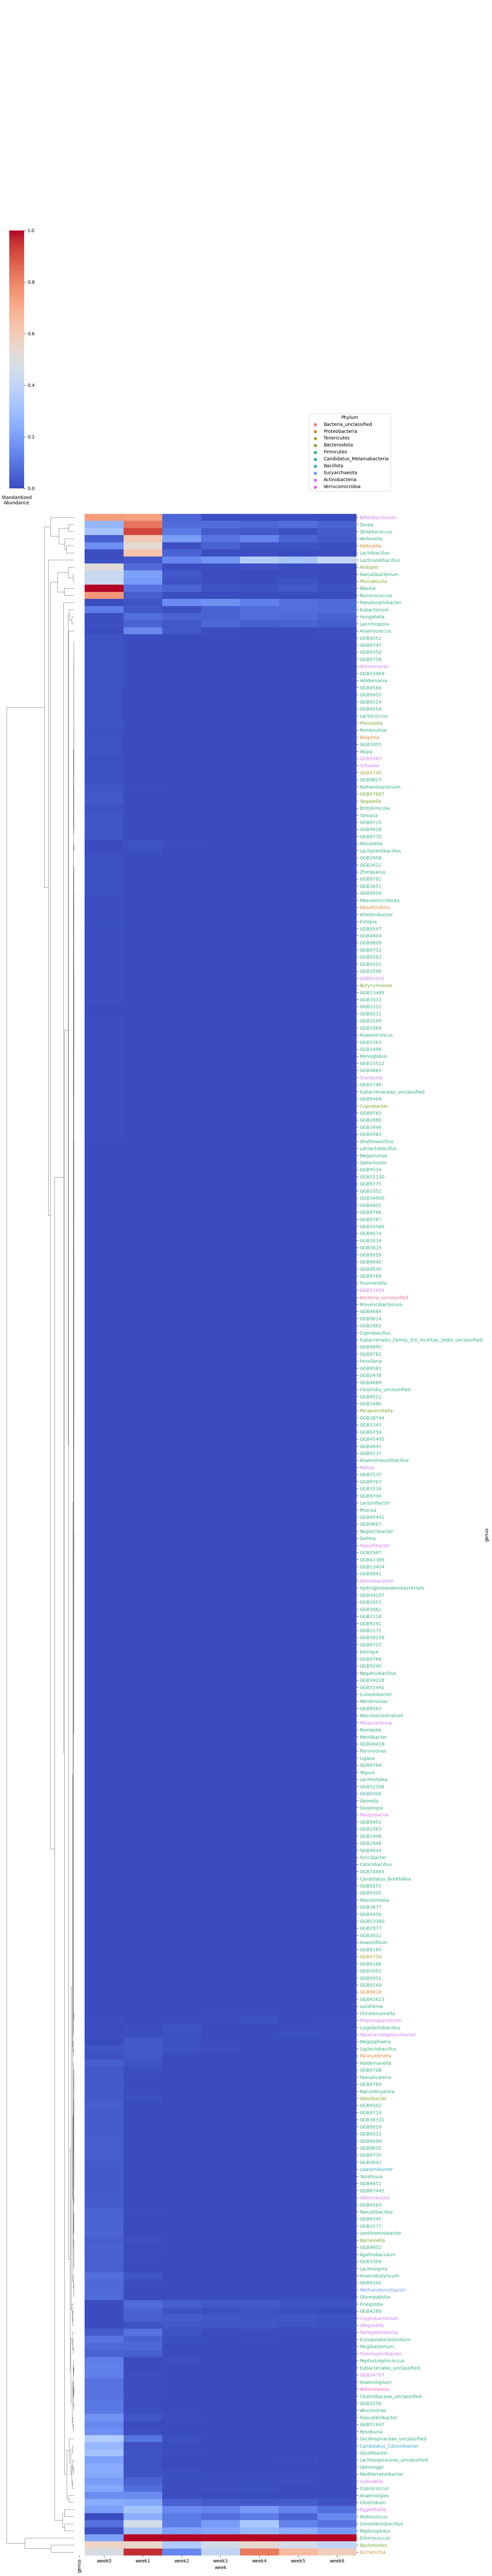

In [383]:
plot_heatmap(V107_fm_sig_extracted, 0)

In [361]:
V107_wlx_R = V107_wlx_sig_extracted[V107_wlx_sig_extracted["group"] == "R"]
V107_wlx_NR = V107_wlx_sig_extracted[V107_wlx_sig_extracted["group"] == "NR"]

In [363]:
# Renaming column
V107_overlap_sig = V107_overlap_sig.rename(columns={"week": "day"})

# Adding custom order of days
day_order = ["day0", "day4", "day8", "day12"]

# Convert to categorical to show in the plot with custom day order
V107_overlap_sig["week"] = pd.Categorical(
    V107_overlap_sig["week"],
    categories=day_order,
    ordered=True
)

# Plotting function
graph = sns.catplot(
    data=V107_overlap_sig,
    x="week",
    y="abundance",
    hue="group",
    col="genus",
    kind="box",
    col_wrap=5,
    height=3,
    sharey=False
)

# Setting x-axis
for ax in graph.axes.flat:
    ax.set_xticklabels(day_order)
    ax.set_xlabel("Week")
    ax.tick_params(labelbottom=True)

graph.set_titles("{col_name}")

#graph.savefig("E975_wlx_sig_overlap.png", dpi=300, bbox_inches="tight")
plt.show()

KeyError: 'week'

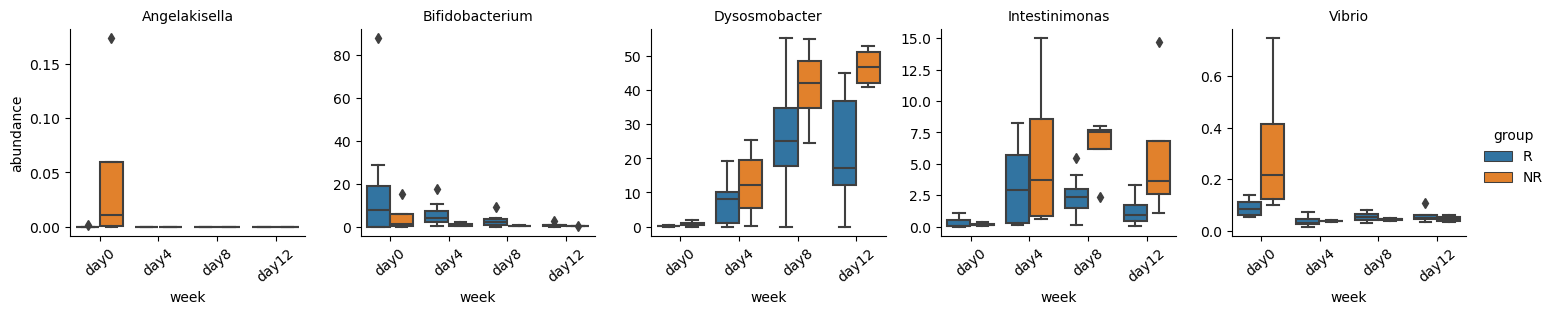

In [386]:
# Plotting function
graph = sns.catplot(
    data=E975_overlap_sig,
    x="week",
    y="abundance",
    hue="group",
    col="genus",
    kind="box",
    col_wrap=5,
    height=3,
    sharey=False
)

graph.set_titles("{col_name}")

for ax in graph.axes.flat:
    ax.tick_params(axis='x', rotation=40)

graph.savefig("E975_wlx_sig_overlap.png", dpi=300, bbox_inches="tight")
plt.show()